## Pre-processing and Visualization

In [1]:
# Import the required libraries.
import copy
import math
import queue
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter
from string import ascii_lowercase
from itertools import combinations
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_recall_fscore_support

In [2]:
# Set the random seed.
random.seed(14)
np.random.seed(14)

In [3]:
# Read the dataset.
data = pd.read_csv('../ensemble_data.csv')

In [4]:
data = data.apply(lambda x: x.astype(str).str.lower())

In [5]:
data

,type,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [6]:
# Generate the attribute and class datasets.
X = data.loc[:, data.columns != 'type']
Y = data.loc[:, data.columns == 'type']

In [7]:
X.insert(loc = 0, column = 'dummy', value = 0)
Y = (Y != 'e').astype(np.int32)

In [8]:
columns = X.columns[1:]

for col in columns:
    X = pd.concat([X, pd.get_dummies(X[col], prefix = col)], axis = 1)
    X.drop([col], axis = 1, inplace = True)

In [9]:
X = X.values
Y = Y.values

In [10]:
kf = KFold(n_splits = 5, shuffle = True)

## Decision Tree Model

In [11]:
class Node():
    cnt = 0

    def __init__(self, ):
        self.leaf = False
        self.majority_class = None
        self.attribute_index = None
        # Key: attribute_value, Value: child_node
        self.children = dict()
        # Used at inference time, if attribute_index is 0
        self.sent_len_split_val = None
        self.id = Node.cnt
        Node.cnt += 1
    
    def __str__(self,):
        return 'ID: {}  isLeaf: {} majority: {} split_idx: {} split_val = {}'.format(self.id,
                                                                                     self.leaf,
                                                                                     self.majority_class,
                                                                                     self.attribute_index,
                                                                                     list(self.children.keys()))

    def __repr__(self):
        return str(self)
    
    def traverse_print(self,):
        print(self)
        for _, child in self.children:
              child.traverse_print()

    @classmethod
    def reset_cnt(cls,):
        cls.cnt = 0

In [12]:
class DecisionTree():
    
    # Score has to be from 'entropy', 'gini', 'misclassification'.
    def __init__(self, score = 'entropy'):
        score_functions = {'entropy': (DecisionTree.compute_entropy, DecisionTree.get_gain_entropy),
           'gini': (DecisionTree.compute_gini, DecisionTree.get_gain_gini),
           'misclassification': (DecisionTree.compute_misclassification, DecisionTree.get_gain_misclassification)}
        
        self.root = None
        assert score in score_functions.keys()
        self.score = score
        self.compute_score = score_functions[score][0]
        self.get_gain = score_functions[score][1]
        return
    
    @staticmethod
    def compute_entropy(labels):
        entropy = 0.0
        totSamples = len(labels)
        labelSet = set(labels.reshape(-1))
        for label in labelSet:
            prob = np.sum(labels == label) / totSamples
            if prob > 1e-12:
                entropy -= np.log(prob) * prob
        
        return entropy
    
    @staticmethod
    def get_gain_entropy(parent_info, data_i, labels):
        attr_split_info = 0
        attr_count = dict()
        for attr_val in set(data_i.reshape(-1)):
            ids = np.where(data_i == attr_val)[0]
            attr_count[attr_val] = len(ids)
            attr_split_info += attr_count[attr_val] * DecisionTree.compute_entropy(labels[ids])
        attr_gain = parent_info - attr_split_info
        attr_gain_ratio = DecisionTree.compute_dict_entropy(attr_count) * attr_gain
        return attr_gain, attr_gain_ratio, attr_count.keys()
    
    @staticmethod
    def compute_dict_entropy(attr_count):
        entropy = 0
        totSamples = sum(attr_count.values())
       
        labelSet = attr_count.keys()
        for label in labelSet:
            prob = attr_count[label] / totSamples
            if prob > 1e-12:
                entropy -= np.log(prob) * prob
        return entropy
    
    @staticmethod
    def compute_gini(labels):
        prob_sq = 0.0
        totSamples = len(labels)
        labelSet = set(labels.reshape(-1))
        for label in labelSet:
            prob = np.sum(labels == label) / totSamples
            if prob > 1e-12:
                prob_sq += prob*prob
        return 1-prob_sq
        
    
    @staticmethod
    def get_gain_gini(parent_info, data_i, labels):
        attr_split_info = 0
        attr_count = dict()
        for attr_val in set(data_i.reshape(-1)):
            ids = np.where(data_i == attr_val)[0]
            attr_count[attr_val] = len(ids)
            attr_split_info += attr_count[attr_val] * DecisionTree.compute_gini(labels[ids])
        attr_split_info /= data_i.shape[0]
        
        attr_gain = parent_info - attr_split_info

        return attr_gain, attr_gain, attr_count.keys()

    @staticmethod
    def compute_misclassification(labels):
        max_prob = -1
        totSamples = len(labels)
        labelSet = set(labels.reshape(-1))
        for label in labelSet:
            prob = np.sum(labels == label) / totSamples
            if prob > max_prob:
                max_prob = prob
        
        return 1-max_prob
    
    @staticmethod
    def get_gain_misclassification(parent_info, data_i, labels):
        attr_split_info = -1
        attr_count = dict()

        for attr_val in set(data_i.reshape(-1)):
            ids = np.where(data_i == attr_val)[0]
            attr_count[attr_val] = len(ids)
            attr_split_info = attr_count[attr_val] * DecisionTree.compute_misclassification(labels[ids])
        attr_split_info /= data_i.shape[0]
        attr_gain = parent_info - attr_split_info

        return attr_gain, attr_gain, attr_count.keys()
    
    def split_node(self, parent, data, labels, used_attr_index):
        num_instances = data.shape[0]
        parent_info = self.compute_score(labels) * num_instances
        parent.majority_class = Counter(labels.reshape(-1)).most_common(1)[0][0]
        
        if parent_info == 0 :
            parent.leaf = True
        
        best_attr_index = None
        best_info_gain = -float('inf')
        best_gain_ratio = -float('inf')
        best_attr_keys = None
        sent_len_split_val = stats.mode(data[:, 0])[0][0]
        le_ids = np.where(data[:, 0] <= sent_len_split_val)[0]
        gt_ids = np.where(data[:, 0] > sent_len_split_val)[0]
        data_0 = np.zeros(data.shape[0], dtype=np.int32)
        data_0[gt_ids] = 1
        attr_gain, attr_gain_ratio, attr_count_keys = self.get_gain(parent_info, data_0, labels)

        if best_gain_ratio < attr_gain_ratio and  attr_gain_ratio > 0 :
                best_attr_index = 0
                best_info_gain = attr_gain
                best_gain_ratio = attr_gain_ratio
                best_attr_keys = attr_count_keys
        
        for i in range(1, data.shape[1]): # starts from 1 as zero is sentence length (always).
            if i in used_attr_index:
                continue
            attr_gain, attr_gain_ratio, attr_count_keys = self.get_gain(parent_info, data[:, i], labels)
            if best_gain_ratio < attr_gain_ratio:
                best_attr_index = i
                best_info_gain = attr_gain
                best_gain_ratio = attr_gain_ratio
                best_attr_keys = attr_count_keys
        if best_gain_ratio <= 0 or len(best_attr_keys) == 1 :
            parent.leaf = True
            return []
        else:
            parent.attribute_index =  best_attr_index
            parent.children = { i: Node() for i in best_attr_keys}
            to_return = []
            if best_attr_index != 0:
                used_attr_index.append(best_attr_index)
                for i in best_attr_keys:
                    inds = np.where(data[:, best_attr_index] == i)[0]
                    to_return.append( (parent.children[i], data[inds], labels[inds], used_attr_index) )
            else:
                parent.sent_len_split_val = sent_len_split_val

                for i in best_attr_keys:
                    inds = np.where(data_0 == i)[0]
                    to_return.append( (parent.children[i], data[inds], labels[inds], used_attr_index) )

            return to_return
    
    def build_tree(self, data, labels):
        traversal_q = queue.Queue()
        root = Node()
        self.root = root
        traversal_q.put_nowait( (root, data, labels, [] ))

        while not traversal_q.empty():
            node_to_split = traversal_q.get_nowait()
            child_nodes = self.split_node(*node_to_split)
            for child in child_nodes:
                traversal_q.put_nowait(child)

        return root
    
    def split_infer(self, node, data, data_indices):
        if node.leaf:
            return (True, data_indices, np.zeros( (data.shape[0]), dtype = np.int32) + node.majority_class)
        else:
            to_queue = []
            if(node.attribute_index == 0):
                left_idx = np.where(data[:,0] <= node.sent_len_split_val)[0]
                right_idx = np.where(data[:,0] > node.sent_len_split_val)[0]
                to_queue.append( (node.children[0], data[left_idx], data_indices[left_idx]) )
                to_queue.append( (node.children[1], data[right_idx], data_indices[right_idx]) )
                return (False, to_queue)
            else:
                for i in node.children.keys():
                    split_inds = np.where( data[:, node.attribute_index]  == i)[0]
                    if len(split_inds) > 0:
                        to_queue.append( (node.children[i], data[split_inds], data_indices[split_inds]) )
                return (False, to_queue)
    
    def split_infer_depth(self, node, data, data_indices, depth):
        if node.leaf or depth >= 3:
            return (True, data_indices, np.zeros( (data.shape[0]), dtype = np.int32) + node.majority_class)
        else:
            to_queue = []
            if(node.attribute_index == 0):
                left_idx = np.where(data[:,0] <= node.sent_len_split_val)[0]
                right_idx = np.where(data[:,0] > node.sent_len_split_val)[0]
                to_queue.append( (node.children[0], data[left_idx], data_indices[left_idx],depth+1) )
                to_queue.append( (node.children[1], data[right_idx], data_indices[right_idx], depth+1) )
                return (False, to_queue)
            else:
                for i in node.children.keys():
                    split_inds = np.where( data[:, node.attribute_index]  == i)[0]
                    if len(split_inds) > 0:
                        to_queue.append( (node.children[i], data[split_inds], data_indices[split_inds],depth+1) )
                return (False, to_queue)
    
    def get_labels(self, data):
        root = self.root
        data_idx = np.arange(data.shape[0], dtype = np.int32)
        labels = np.zeros( (data.shape[0]), dtype = np.int32) + -1
        traversal_q = queue.Queue()
        traversal_q.put_nowait( (root, data, data_idx ))
        while not traversal_q.empty():
            node_to_split = traversal_q.get_nowait()
            split_return = self.split_infer(*node_to_split)
            if split_return[0]:
                labels[split_return[1]] = split_return[2]
            else:
                for child in split_return[1]:
                    traversal_q.put_nowait(child)
        return labels
    
    def get_labels_depth(self, data):
        root = self.root
        data_idx = np.arange(data.shape[0], dtype = np.int32)
        labels = np.zeros( (data.shape[0]), dtype = np.int32) + -1
        traversal_q = queue.Queue()
        traversal_q.put_nowait( (root, data, data_idx ,0))
        while not traversal_q.empty():
            node_to_split = traversal_q.get_nowait()
            split_return = self.split_infer_depth(*node_to_split)
            if split_return[0]:
                labels[split_return[1]] = split_return[2]
            else:
                for child in split_return[1]:
                    traversal_q.put_nowait(child)
        return labels

In [13]:
def get_scores(Y_test_idx, y_pred_test, average = 'macro'):
    acc = (y_pred_test == Y_test_idx).mean()
    prec, rec, fscore, _ = precision_recall_fscore_support(Y_test_idx, y_pred_test, average=average)
    return round(acc, 5), round(prec, 5), round(rec, 5), round(fscore, 5)

In [14]:
dtree = DecisionTree('misclassification')
decision_tree_scores = []

print('For 5-Fold Cross Validation')
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    root = dtree.build_tree(data = X_train, labels = Y_train)
    print(dtree.root)

    y_pred_test = dtree.get_labels(data = X_val)
    decision_tree_scores.append(get_scores(Y_val.ravel(), y_pred_test))
    print('Acc: {}, Prec: {}, Rec: {}, Fscore: {}\n'.format(*get_scores(Y_val.ravel(), y_pred_test)))

For 5-Fold Cross Validation
ID: 0  isLeaf: False majority: 0 split_idx: 2 split_val = [0, 1]
Acc: 0.99938, Prec: 0.99943, Rec: 0.99934, Fscore: 0.99938

ID: 87  isLeaf: False majority: 0 split_idx: 2 split_val = [0, 1]
Acc: 1.0, Prec: 1.0, Rec: 1.0, Fscore: 1.0

ID: 174  isLeaf: False majority: 0 split_idx: 2 split_val = [0, 1]
Acc: 1.0, Prec: 1.0, Rec: 1.0, Fscore: 1.0

ID: 261  isLeaf: False majority: 0 split_idx: 2 split_val = [0, 1]
Acc: 1.0, Prec: 1.0, Rec: 1.0, Fscore: 1.0

ID: 348  isLeaf: False majority: 0 split_idx: 2 split_val = [0, 1]
Acc: 1.0, Prec: 1.0, Rec: 1.0, Fscore: 1.0



## Adaboost Model

In [15]:
# Decision Stump is used as classifier in this implementation of Adaboost.
class DecisionStump(DecisionTree):

    def __init__(self):
        self.polarity = 1
        self.feature_index = None
        self.threshold = None
        self.alpha = None

class Adaboost():

    def __init__(self, n_clf = 5):
        self.n_clf = n_clf

    def fit(self, X, Y):
        n_samples, n_features = np.shape(X)
        w = np.full(n_samples, (1 / n_samples))
        
        self.clfs = []
        for _ in range(self.n_clf):
            clf = DecisionStump()
            min_error = float('inf')

            for feature_i in range(n_features):
                feature_values = np.expand_dims(X[:, feature_i], axis = 1)
                unique_values = np.unique(feature_values)

                for threshold in unique_values:
                    p = 1
                    prediction = np.ones(np.shape(Y))
                    prediction[X[:, feature_i] <= threshold] = 0
                    error = sum(w[Y != prediction])

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_index = feature_i
                        min_error = error

            clf.alpha = 0.5 * math.log((1.0 - min_error) / (min_error + 1e-10))
            predictions = np.ones(np.shape(Y))
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            predictions[negative_idx] = 0
            w *= np.exp(-clf.alpha * Y * predictions.ravel())
            w /= np.sum(w)
            self.clfs.append(clf)

    def predict(self, X):
        n_samples = np.shape(X)[0]
        y_pred = np.zeros((n_samples, 1))

        for clf in self.clfs:
            predictions = np.ones(np.shape(y_pred))
            negative_idx = (clf.polarity * X[:, clf.feature_index] <= clf.polarity * clf.threshold)
            predictions[negative_idx] = 0
            y_pred += clf.alpha * predictions

        y_pred = np.sign(y_pred).flatten()
        return y_pred

In [16]:
# Adaboost classification with 5 weak classifiers.
adaboost_scores = []

print('For 5-Fold Cross Validation')
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    ada = Adaboost(n_clf = 5)
    ada.fit(X_train, Y_train.ravel())
    y_pred_test = dtree.get_labels(data = X_val)

    adaboost_scores.append(get_scores(Y_val.ravel(), y_pred_test))
    print('Acc: {}, Prec: {}, Rec: {}, Fscore: {}\n'.format(*get_scores(Y_val.ravel(), y_pred_test)))

For 5-Fold Cross Validation
Acc: 1.0, Prec: 1.0, Rec: 1.0, Fscore: 1.0

Acc: 1.0, Prec: 1.0, Rec: 1.0, Fscore: 1.0

Acc: 1.0, Prec: 1.0, Rec: 1.0, Fscore: 1.0

Acc: 1.0, Prec: 1.0, Rec: 1.0, Fscore: 1.0

Acc: 1.0, Prec: 1.0, Rec: 1.0, Fscore: 1.0



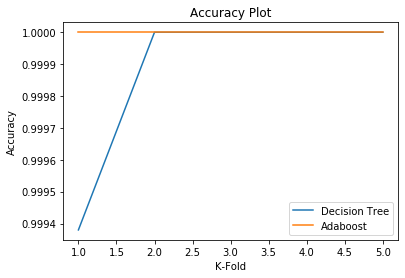

In [17]:
x = [1, 2, 3, 4, 5]
y1 = [elem[0] for elem in decision_tree_scores]
plt.plot(x, y1, label = "Decision Tree")
y2 = [elem[0] for elem in adaboost_scores]
plt.plot(x, y2, label = "Adaboost")
plt.xlabel('K-Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

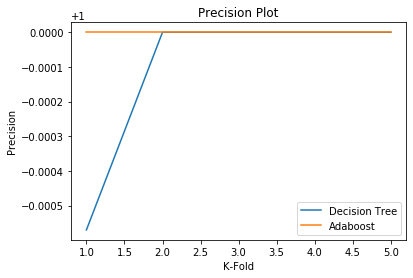

In [21]:
y1 = [elem[1] for elem in decision_tree_scores]
plt.plot(x, y1, label = "Decision Tree")
y2 = [elem[1] for elem in adaboost_scores]
plt.plot(x, y2, label = "Adaboost")
plt.xlabel('K-Fold')
plt.ylabel('Precision')
plt.title('Precision Plot')
plt.legend()
plt.show()

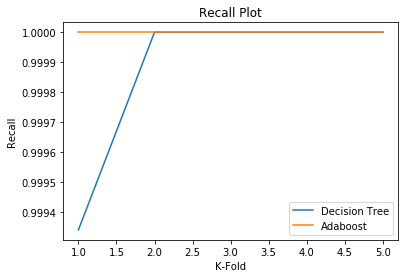

In [19]:
y1 = [elem[2] for elem in decision_tree_scores]
plt.plot(x, y1, label = "Decision Tree")
y2 = [elem[2] for elem in adaboost_scores]
plt.plot(x, y2, label = "Adaboost")
plt.xlabel('K-Fold')
plt.ylabel('Recall')
plt.title('Recall Plot')
plt.legend()
plt.show()

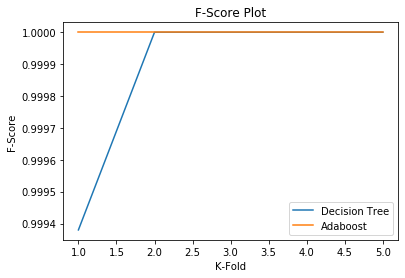

In [20]:
y1 = [elem[3] for elem in decision_tree_scores]
plt.plot(x, y1, label = "Decision Tree")
y2 = [elem[3] for elem in adaboost_scores]
plt.plot(x, y2, label = "Adaboost")
plt.xlabel('K-Fold')
plt.ylabel('F-Score')
plt.title('F-Score Plot')
plt.legend()
plt.show()